In [1]:
import numpy             as     np
import matplotlib.pyplot as     plt
from   astropy.table     import Table
from   astropy.cosmology import FlatLambdaCDM
from   matplotlib.pyplot import cm
import matplotlib
from   scipy.special     import gamma

#Things conatined in this code:
    # - Converting from instrumental units (pixels and apparent mags) into more physical units (kpc and Absolute Mags)
    # - Milky Way (MW) extinction correction applied to mags
    # - Calculating total stellar masses
    # - Creating a new fits file with the physical units added as new columns (kpc has '_kpc' on the end, and absolute mags have capitalised m) and the total stellar masses.

    # - Doing some sanity checks, including:
        # -- Seeing what how the effective radii and magnitudes change for different bands
        # -- Making sure I can recover total magnitudes analytically
        # -- See if I can recover total magnitudes numerically


In [2]:
# _________________________________________________________
# _________________________________________________________
#-- Import files--#
# _________________________________________________________

#Path where all the files are for this/ where this code is located
#path = '/Users/jenniferhardwick/Desktop/OneDrive - The University of Western Australia/PhD/xGASS_Decomposition_Catalogue/'
path = '/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/xGASS_Decomposition_Catalogue/'

#--- Robins xGASS Decomposition Catalogue
#First import the catalogue into an astropy.table
xGASS_data_astropyTable = Table.read(path+'Catalogues/xGASS_Decomposition_Catalogue_11-05-2020.fits')
#Need to save units before converting to pandas (as units are lost)
xGASS_unit = {}
for label in xGASS_data_astropyTable.keys() :
    xGASS_unit[label] = str(xGASS_data_astropyTable[label].unit)
#Then convert to pandas data frame
xGASS_data = xGASS_data_astropyTable.to_pandas()

#For some reason it imports strings as 'byte10' instead, so convert them to strings:
key = xGASS_data.keys() 
for idx in range(len(key)):
    if xGASS_data.dtypes[idx] == object:
        xGASS_data[key[idx]] = xGASS_data[key[idx]].str.decode("utf-8")
        
xGASS_data.info()

#--- Metadata from Robin
#Also import all of the relevant metadata (like mag_zeros) into an astropy.table
metadata_astropyTable   = Table.read(path+'Catalogues/xGASS_BD-decomposition_SDSS_metadata_03-07-20.fits')
#Then convert to pandas data frame
metadata = metadata_astropyTable.to_pandas()

#For some reason it imports strings as 'byte10' instead, so convert them to strings:
key = metadata.keys() 
for idx in range(len(key)):
    if metadata.dtypes[idx] == object:
        metadata[key[idx]] = metadata[key[idx]].str.decode("utf-8")

#Whether you want to apply MW Extinction corrections to the data
MW_Extinction_on = True

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Columns: 138 entries, GASSID to Comments
dtypes: float32(1), float64(131), int16(1), int64(1), object(4)
memory usage: 1.2+ MB


In [3]:
# _________________________________________________________
# _________________________________________________________
#-- Delete unused columns to make the table less chunky--#
# _________________________________________________________

#Deleting the stuff I don't need...
#otherwise the data frame gets very large, and I don't use a fair chunk of it (so just delete those columns)

for band in ['g','r','i']:
    for comp in ['','D','B']:
        for key in ['xcen'+comp+'_'+band,'xcen'+comp+'_'+band+'_err',
                    'ycen'+comp+'_'+band,'ycen'+comp+'_'+band+'_err',
                    'ang'+comp+'_'+band ,'ang'+comp+'_'+band+'_err']:
            try:
                xGASS_data = xGASS_data.drop(columns=key)
            except KeyError:
                pass

xGASS_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 93 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GASSID           1177 non-null   object 
 1   RA               1177 non-null   float64
 2   DEC              1177 non-null   float64
 3   zSDSS            1177 non-null   float32
 4   mag_g            1176 non-null   float64
 5   mag_g_err        1175 non-null   float64
 6   re_g             1176 non-null   float64
 7   re_g_err         1175 non-null   float64
 8   nser_g           1176 non-null   float64
 9   nser_g_err       1175 non-null   float64
 10  axrat_g          1176 non-null   float64
 11  axrat_g_err      1175 non-null   float64
 12  box_g            1176 non-null   float64
 13  chisq_g_1C       1176 non-null   float64
 14  magB_g           1176 non-null   float64
 15  magB_g_err       1175 non-null   float64
 16  magD_g           1176 non-null   float64
 17  magD_g_err    

In [4]:
# _________________________________________________________
# _________________________________________________________
#-- Import and Calculate MW extinction--#
# _________________________________________________________


# Open file
f = open('Catalogues/extinction.txt', 'r')

# Read and ignore header lines
for i in range(16):
    f.readline()

extinctions = {}
    
extinctions['RA']        = np.zeros(len(xGASS_data['GASSID']))
extinctions['DEC']       = np.zeros(len(xGASS_data['GASSID']))
extinctions['E_B_V']     = np.zeros(len(xGASS_data['GASSID']))
extinctions['E_B_V_err'] = np.zeros(len(xGASS_data['GASSID']))

# Loop over lines and extract variables of interest
i = 0
for line in f:
    line    = line.strip()
    columns = line.split()
    
    extinctions['RA'][i]        = float(columns[0]) #J2000
    extinctions['DEC'][i]       = float(columns[1]) #J2000
    extinctions['E_B_V'][i]     = float(columns[3]) #mag (Assuming apparent mags)
    extinctions['E_B_V_err'][i] = float(columns[5]) #standard deviation of E(B-V)
    i +=1
    
extinctions['A_g'] = 3.303*extinctions['E_B_V'] # -\
extinctions['A_r'] = 2.285*extinctions['E_B_V'] #   - Using values from Table 6 in Schlafly & Finkbeiner (2011)
extinctions['A_i'] = 1.698*extinctions['E_B_V'] # -/

extinctions['A_g_err'] = 3.303*extinctions['E_B_V_err'] # -\
extinctions['A_r_err'] = 2.285*extinctions['E_B_V_err'] #   - Using values from Table 6 in Schlafly & Finkbeiner (2011)
extinctions['A_i_err'] = 1.698*extinctions['E_B_V_err'] # -/


f.close()

In [5]:
# _________________________________________________________
# _________________________________________________________
#-- Unit Conversions--#
# _________________________________________________________

#First step is to convert everything into physical units (e.g. pixels -> arcsecs -> kpc and apparent mags -> absolute mags) .

#All of the column labels/ keys from the table
labels = xGASS_data.keys()

#Redshift of each galaxy taken from SDSS
z = xGASS_data['zSDSS']
cosmo = FlatLambdaCDM(H0=70,Om0=0.3,Tcmb0 = 2.725) #Defining our cosmology (Using the same cosmology as Cook 2019)

##For now I don't want to deal with errors, so I am removing them from the columns that have their units changed.
#index = []
#for i in range(len(labels)):
#    if labels[i][-3:] != 'err':
#        index.append(i)
#labels = np.array(labels)[index]

labels = labels.tolist()

for i in range(len(labels)-1):#starts with 0 index
    #Find all columns in the unit pixel...
    if xGASS_unit[labels[i]] == 'pixels':
        #Both errors and actual data are treated the same way as the conversion is assumed to have no error.
        
        #Need to go from pixels to arcseconds and pixel size: 0.396 [arcsec/pixel], then need to go from arcsecs to kpc
        xGASS_data[labels[i]+'_kpc'] = (xGASS_data[labels[i]]*0.396)/cosmo.arcsec_per_kpc_proper(z)

        xGASS_unit[labels[i]+'_kpc']  = 'kpc'

    #Find all the columns with apparent magnitudes
    if xGASS_unit[labels[i]] == 'mags':
        
        if labels[i][-3:] != 'err':
            #Actual data not an error
            #Apply Milky Way Extinction:
            if MW_Extinction_on:
                for band in ['g','r','i']:
                    if labels[i][-1] == band:
                        #once you've found the band this label is, perform the MW extinction
                        xGASS_data[labels[i]] = xGASS_data[labels[i]] - extinctions['A_'+band]
                        #each label will only be in one band so can then break (save iterating over the others)
                        break
                        
            #Defining a new column, which replaces the lower case m in the column title to an upper case M (e.g. magD_r will have a new column created called MagD_r which will have the equivalent absolute magnitudes in it).
            xGASS_data['M'+labels[i][1:]] = xGASS_data[labels[i]] - np.array(cosmo.distmod(z)) 
            xGASS_unit['M'+labels[i][1:]] = 'Absolute Mags'
        
        else:
            #An error so the error propogation is needed:
            #Milky Way Extinction affects the error but the distance modulus is not needed
            if MW_Extinction_on:
                for band in ['g','r','i']:
                    if labels[i][-1] == band:
                        #once you've found the band this label is, perform the MW extinction
                        xGASS_data[labels[i]] = np.sqrt(xGASS_data[labels[i]]**2 + extinctions['A_'+band+'_err']**2)
                        
                        xGASS_data['M'+labels[i][1:]] = xGASS_data[labels[i]] 
                        xGASS_unit['M'+labels[i][1:]] = 'Absolute Mags'
                        
                        #each label will only be in one band so can then break (save iterating over the others)
                        break


In [6]:
# _________________________________________________________
# _________________________________________________________
#-- Aligning MetaData with xGASS Data--#
# _________________________________________________________

#For the xGASS_data I assume that the galaxies are in the same order to every column (which is a fair assumption), but in the meta data file they aren't. Need to cross match using their Galaxy IDs, so that my first assumption is correct for both catalogues.
#All I really need out of the metadata (at least for now) is the mag zeros for the three different bands.

order = []
for i in range(len(xGASS_data['GASSID'])): #For every id in the data
    order.append(np.argwhere(np.array(metadata['GASSID']) == xGASS_data['GASSID'][i])[0][0]) #find that ID in the metadata and record its location

magzero = {}
magzero['g'] = np.array(metadata['magzero_g'][order])
magzero['r'] = np.array(metadata['magzero_r'][order])
magzero['i'] = np.array(metadata['magzero_i'][order])

#Now this is the magzero for the different bands, in the same order as xGASS_data.

xGASS_data['magzero_g'] = magzero['g']
xGASS_data['magzero_r'] = magzero['r']
xGASS_data['magzero_i'] = magzero['i']


In [7]:
# _________________________________________________________
# _________________________________________________________
#-- Calculating Total Quantities (combining disc and bulge components) --#
# _________________________________________________________

for band in ['g','r','i']:
    xGASS_data['magT_'+band] = -2.5*np.log10(10**(-0.4*xGASS_data['magD_'+band])+10**(-0.4*xGASS_data['magB_'+band]))
    xGASS_data['MagT_'+band] = xGASS_data['magT_'+band] - np.array(cosmo.distmod(z))

    #This error propogation is long so going to split it up: it is (-2.5 * sig_u ) / (2.303 * u)
    sig_u = np.sqrt( (-0.4*np.log(10)*xGASS_data['magD_'+band+'_err']*10**(-0.4*xGASS_data['magD_'+band]))**2 + (-0.4*np.log(10)*xGASS_data['magB_'+band+'_err']*10**(-0.4*xGASS_data['magB_'+band]))**2 ) 
    u = 10**(-0.4*xGASS_data['magD_'+band])+10**(-0.4*xGASS_data['magB_'+band])
    xGASS_data['magT_'+band+'_err'] = (-2.5 * sig_u ) / (2.303 * u)
    xGASS_data['MagT_'+band+'_err'] = xGASS_data['magT_'+band+'_err']
    

In [8]:
# _________________________________________________________
# _________________________________________________________
#-- Calculating Total Stellar Masses--#
# _________________________________________________________

#log(M/L ratio) = -0.977 + (1.157 * (g-i) ) #This is for g - i colour, using r band luminance (I guess this means later I use the r band luminosity)
#^This is in solar units, which means that the luminosity and mass are both in solar units

#stellar mass = (r band luminosity [L_sun]) * (M/L ratio)

#L = 10^(M-Msun/-2.5)
#For SDSS r band the Absolute AB magnitude is 4.65 (Taken from Lucas slides lecture 7, which I believe he got from http://mips.as.arizona.edu/~cnaw/sun.html )

for comp in ['','D','T']: #single component fits, disc components and total of bulge + disc components
    xGASS_data['log10TotM*'+comp] = ((xGASS_data['Mag'+comp+'_r']-4.65)/-2.5)  -0.977 + (1.157 * (xGASS_data['Mag'+comp+'_g']  - xGASS_data['Mag'+comp+'_i']))
    
    #Propogated error from the magnitudes:
    prop_err = np.sqrt( (xGASS_data['Mag'+comp+'_r_err']/-2.5)**2 + (1.157*xGASS_data['Mag'+comp+'_g_err'])**2 + (1.1157*xGASS_data['Mag'+comp+'_i_err'])**2 ) 
    #Zibetti quotes an error of 0.15 dex in converting from magnitudes to stellar masses, so add this error to the propogated error:
    xGASS_data['log10TotM*'+comp+'_err'] = np.sqrt( prop_err**2 + 0.15**2 )
    
#In robins catalogue he logs his solar masses, so I am doing the same to be consistent.

xGASS_data['log10TotM*B'] = np.log10(10**xGASS_data['log10TotM*T'] - 10**xGASS_data['log10TotM*D'])


/home/jenniferhardwick/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# _________________________________________________________
# _________________________________________________________
#-- Calculating Sky Noise Levels--#
# _________________________________________________________
#http://classic.sdss.org/dr4/algorithms/fluxcal.html

# The rms of the sky: metadata['SkyRMS_r'][order]
# The value of the sky: metadata['SkyVal_r'][order]

counts = np.array(metadata['SkyRMS_r'][order]).astype(float) #I don't know why, but this term is a string not an int/ float

#f/f0 = counts/exptime * 10^0.4*(aa + kk * airmass):
f_f0 = (counts/np.array(metadata['exptime'][order])) * 10**( 0.4*(np.array(metadata['phot_a_r'][order]) + np.array(metadata['phot_k_r'][order])*np.array(metadata['airmass_r'][order])) )

RMS_mag_per_sqarcsec = -2.5 * np.log10(f_f0/(0.396**2)) #mag/arcsec^-2
#RMS_mag_per_sqarcsec = RMS_mag

#Need to save this threshold of where we trust the measurements in mag.arcsec^-2
xGASS_data['RMS'] = RMS_mag_per_sqarcsec


In [10]:
# _________________________________________________________
# _________________________________________________________
#-- Export Data --#
# _________________________________________________________

#I have now converted everything into physical units, so the data frame can be exported to use without having to do the conversions each time:

xGASS_data = Table.from_pandas(xGASS_data)
metadata   = Table.from_pandas(metadata)

if MW_Extinction_on:
    #MW extinction
    xGASS_data.write(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction.fits',overwrite=True)
else:
    #No MW extinction
    xGASS_data.write(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL.fits',overwrite=True)

#From here on this code is just doing some sanity checks to make sure I understand how the total magnitude is recorded and how to recover it numerically if I need to. 
#I also plot some example sersic profiles just to see how they look.


In [11]:
# _________________________________________________________
# _________________________________________________________
#-- Helful Functions --#
# _________________________________________________________

def Sersic_Profile(Re,Ie,n):
    ''' 
    This gives a surface density profile from a sersic profile:
    Sigma(R) = Ie * exp(-bn((R/Re)**(1/n)-1))    
    (bn is a numerical coefficient that depends on n)

    Parameters
    ----------
    Re : float
        The effective radius [kpc]
    Ie : float
        The intensity at Re [W.m^-2.Hz^-1.kpc^-2]
    n  : float
        The sersic index [unit-less]

    Returns
    -------
    2D numpy array 
        row1: R values from 0 to 10Re [kpc]
        row2: Light Intensity Sersic profile at each R value [W.m^-2.Hz^-1.kpc^-2]

    '''
    
    R = np.arange(0,10,0.001) #In units of Re
    bn = (2*n) - (1.0/3.0) + (0.009876/float(n))
    return np.array([R*Re,Ie*np.e**( -bn*(R**(1.0/float(n))-1) ) ])

def NumericalIntegral(R,Func):
    '''
    This integrates a function numerically, within the maximum R value given.
    
    Parameters
    ----------
    R : array
        Radial values of the function
        
    Func: array
        Values of a function at each radii that is to be integrated numerically
    
    Returns
    -------
    float 
        Gives the numerical integral within the maximum R value
    '''
    
    i = range(0,len(R)-1)
    one = np.repeat(1,len(R)-1)
    return np.nansum(np.mean([Func[i],Func[i+one]])*(R[i+one]-R[i]))


def Ie(Re,n,m,mzero):
    '''
    Intensity at the effective radius (Formulas taken from the ProFit paper)
    
    Parameters
    ----------
    Re: list or array
        Effective radii for all galaxies [kpc]
    n: list or array
        Sersic index for all galaxies [unit-less]
    m: list or array
        Apparent magnitude for all galaxies [mags]
    mzero: list or array
        Magnitude Zero point for all galaxies [W.m^-2.Hz^-1]
    
    Returns
    -------
    1D numpy array 
        The Intensity at the effective radius for all galaxies [W.m^-2.Hz^-1.kpc^-2]   
    '''
    
    Re    = np.array(Re).astype(float)
    n     = np.array(n).astype(float)
    m     = np.array(m).astype(float)
    mzero = np.array(mzero).astype(float)
    
    b = (2*n) - (1.0/3.0) + (0.009876/n)
    Ltot = (2*np.pi*Re**2*n*gamma(2*n)*np.exp(b)) / (b**(2*n))
    return 10**(-0.4*(m-mzero))/Ltot

def TotMagAnalytic(Ie,Re,n,mzero):
    '''
    This calculates the total magnitude from a sersic profile as R -> infinity
    Taken from Graham and Driver 2005 eqn 5
        
    Parameters
    ----------   
    Ie : list or array
        The intensity at the effective radius [W.m^-2.Hz^-1.kpc^-2] 
    Re : list or array
        The effective radius (or half light radius) [kpc]
    n : list or array
        The sersic index [unit-less]
    mzero : list or array
        The zero point magnitude [W.m^-2.Hz^-1]
        
    Returns
    -------
    1D numpy array 
        The Total magnitude within R -> inf [mags]
    '''
    
    Ie    = np.array(Ie).astype(float)
    Re    = np.array(Re).astype(float)
    n     = np.array(n).astype(float)
    mzero = np.array(mzero).astype(float)
    
    mu_e = -2.5*np.log10(Ie) + mzero
    bn = (2*n) - (1.0/3.0) + (0.009876/n)
    return mu_e - 5*np.log10(Re) - 2.5*np.log10( (2*np.pi*n*np.exp(bn)*gamma(2*n)) / (bn**(2*n)) )



In [12]:
#_________________________________________________________
#_________________________________________________________
#_________________________________________________________
#_________________________________________________________
#____ SANITY  CHECKING / UNDERSTANDING PROCESSES _________
#_________________________________________________________
#_________________________________________________________
#_________________________________________________________



# _________________________________________________________
# _________________________________________________________
#-- Calculate Total Magnitude Numerically --#
# _________________________________________________________

#This chunk of code numerically calculates the total magnitude of each galaxy, given the sersic profile of the galaxy.

TotalLuminosity = {}
TotalMag = {}

#First we define all of the galaxies classed as being 2 component (although this could be done for one-component systems too).
twoComp_galaxies = np.argwhere(xGASS_data['Model']==0)
#Loop over the disc and bulge component in each band
for type in ['D','B']:
    for band in ['g','r','i']:
        TotalLuminosity[type+band] = []
        TotalMag[type+band] = []
        Re    = xGASS_data['re'+type+'_'+band+'_kpc'][twoComp_galaxies] #kpc
        n     = xGASS_data['nser'+type+'_'+band][twoComp_galaxies] #unit-less
        m     = xGASS_data['mag'+type+'_'+band][twoComp_galaxies] #apparent mag
        mzero = magzero[band][twoComp_galaxies] #reference magnitude (in W.m^-2.Hz^-1)
        ie = Ie(Re,n,m,mzero) #W.m^-2.Hz^-1.kpc^-2
        
        for i in range(len(twoComp_galaxies)):
            R = Sersic_Profile(Re[i],ie[i],n[i])[0] #kpc
            y = Sersic_Profile(Re[i],ie[i],n[i])[1] #Same units as Ie/ mzero
            
            #The total Luminosity of the object = int_0^10Re SersicProfile * 2piR dR
            TotalLuminosity[type+band].append(NumericalIntegral(R,y*2*np.pi*R))
            #I then need to convert the Luminosity to Magnitudes again to compare with the initial solution.
            # mag = -2.5 log_10(L) + mzero
            TotalMag[type+band].append(-2.5*np.log10(np.array(TotalLuminosity[type+band][-1])) + mzero[i])
            #records each galaxy individually

# _________________________________________________________
# _________________________________________________________
#-- Calculate Total Magnitude Analytically --#
# _________________________________________________________

#This chunk of code analytically calculates the total magnitude of each galaxy. The formula is explained in Graham & Driver 2005, and is derived from a sersic profile.

tmAnalytic = {}

#First we define all of the galaxies classed as being 2 component (although this could be done for one-component systems too).
twoComp_galaxies = np.argwhere(xGASS_data['Model']==0)
#Loop over the disc and bulge component in each band
for type in ['D','B']:
    for band in ['g','r','i']:
        Re    = xGASS_data['re'+type+'_'+band+'_kpc'][twoComp_galaxies] #kpc
        n     = xGASS_data['nser'+type+'_'+band][twoComp_galaxies] #unit-less
        m     = xGASS_data['mag'+type+'_'+band][twoComp_galaxies] #apparent mag
        mzero = magzero[band][twoComp_galaxies] #reference magnitude (in W.m^-2.Hz^-1)
        ie = Ie(Re,n,m,mzero) #In units of mzero
        
        tmAnalytic[type+band] = TotMagAnalytic(ie,Re,n,mzero) #Record the total mag for each galaxy (vectorised function -> does all of a band and type at once)


In [13]:
#_________________________________________________________
#_________________________________________________________
#_________________________________________________________
#_____________________ PLOTTING __________________________
#_________________________________________________________
#_________________________________________________________



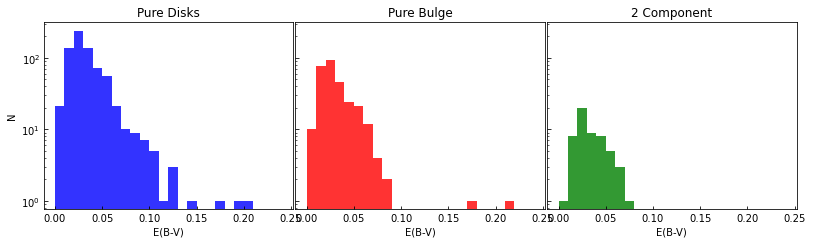

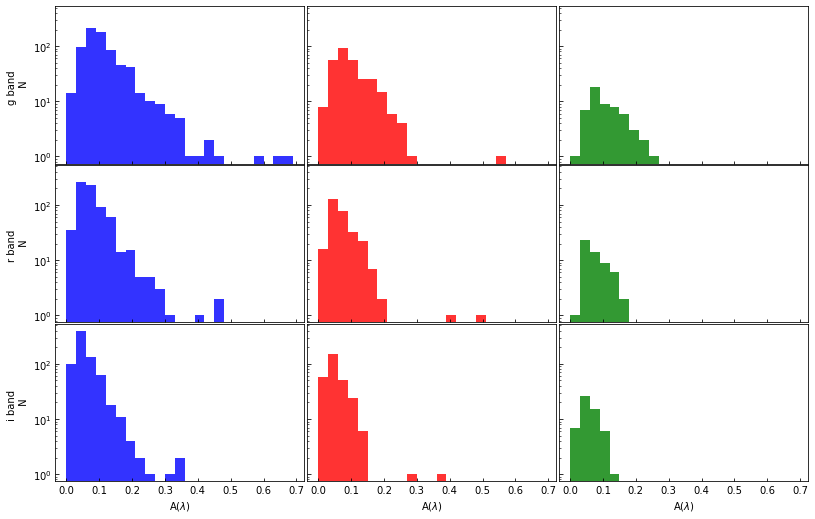

In [14]:
Model = xGASS_data['Model']

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(12,4))
fig.tight_layout(pad=4)
fig.subplots_adjust(hspace=0.01,wspace=0.01)

for ax,m,colour in zip((ax1,ax2,ax3),(0,1,2),['b','r','g']):
    ax.hist(extinctions['E_B_V'][Model == m], color=colour,alpha=0.8,bins=np.arange(0,0.25,0.01))
    ax.tick_params(axis='both',direction='in',which='both')
    ax.set_yscale('log')
    ax.set_xlabel('E(B-V)')

ax1.set_ylabel('N')

ax1.set_title('Pure Disks')
ax2.set_title('Pure Bulge')
ax3.set_title('2 Component')

fig.savefig(path+'Figures/E_B-V.pdf')

#------

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows=3,ncols=3,sharex=True,sharey=True,figsize=(12,8))
fig.tight_layout(pad=4)
fig.subplots_adjust(hspace=0.01,wspace=0.01)

for row,band in zip(((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)),('g','r','i')):
    row[0].set_ylabel(band+' band \n N')
    for ax,m,colour in zip(row,(0,1,2),['b','r','g']):
        ax.hist(extinctions['A_'+band][Model == m], color=colour,alpha=0.8,bins=np.arange(0,0.7,0.03))
        ax.tick_params(axis='both',direction='in',which='both')
        ax.set_yscale('log')

ax7.set_xlabel('A($\lambda$)')
ax8.set_xlabel('A($\lambda$)')
ax9.set_xlabel('A($\lambda$)')

fig.savefig(path+'Figures/A_lambda.pdf')

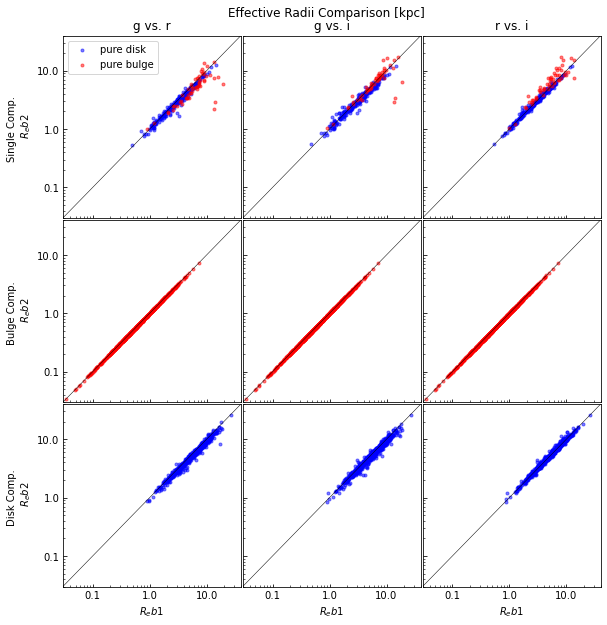

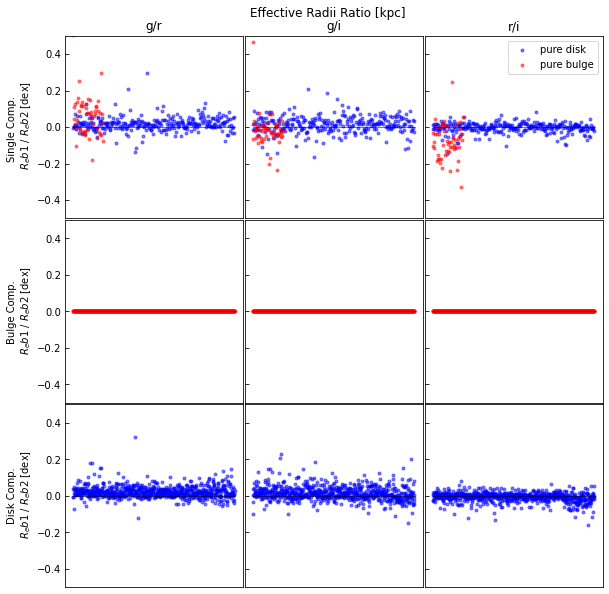

In [15]:
#_________________________________________________________
#_________________________________________________________
#-- Plotting properties in Different Bands (SANITY CHECK)--#
# _________________________________________________________
#Going to plot properties in different bands against each other and see what it looks like :)

Model = xGASS_data['Model']

for p,prop in zip(['re'],['R_{e}']):
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows=3,ncols=3,sharex=True,sharey=True,figsize=(9,9))
    fig.tight_layout(pad=3.8)
    fig.subplots_adjust(wspace=0.01,hspace=0.01)
    if p == 're':
        fig.suptitle('Effective Radii Comparison [kpc]')
    if p == 'mag':
        fig.suptitle('Absolute Magnitude Comparison')
    axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

    for ax in axs:
        ax.tick_params(axis='both',direction='in',which='both')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.set_xlim(0.03,40)
        ax.set_ylim(0.03,40)
        if p == 're':
            ax.plot([0,40],[0,40],color='k',lw=0.5)

    index = np.argwhere(xGASS_data['Model']==1)
    ax1.scatter(xGASS_data[p+'_g_kpc'][index],xGASS_data[p+'_r_kpc'][index],alpha=0.5,marker='.',color='b',label = 'pure disk')
    ax2.scatter(xGASS_data[p+'_g_kpc'][index],xGASS_data[p+'_i_kpc'][index],alpha=0.5,marker='.',color='b')
    ax3.scatter(xGASS_data[p+'_r_kpc'][index],xGASS_data[p+'_i_kpc'][index],alpha=0.5,marker='.',color='b')
    index = np.argwhere(xGASS_data['Model']==2)
    ax1.scatter(xGASS_data[p+'_g_kpc'][index],xGASS_data[p+'_r_kpc'][index],alpha=0.5,marker='.',color='r',label = 'pure bulge')
    ax2.scatter(xGASS_data[p+'_g_kpc'][index],xGASS_data[p+'_i_kpc'][index],alpha=0.5,marker='.',color='r')
    ax3.scatter(xGASS_data[p+'_r_kpc'][index],xGASS_data[p+'_i_kpc'][index],alpha=0.5,marker='.',color='r')

    ax1.set_title('g vs. r')
    ax2.set_title('g vs. i')
    ax3.set_title('r vs. i')

    ax1.set_ylabel('Single Comp. \n $'+prop+'b2}$')
    ax1.legend()

    index = np.argwhere(xGASS_data['Model']==0)
    ax4.scatter(xGASS_data[p+'B_g'+'_kpc'][index],xGASS_data[p+'B_r_kpc'][index],alpha=0.5,marker='.',color='r')#,label='bulge component')
    ax5.scatter(xGASS_data[p+'B_g'+'_kpc'][index],xGASS_data[p+'B_i_kpc'][index],alpha=0.5,marker='.',color='r')
    ax6.scatter(xGASS_data[p+'B_r'+'_kpc'][index],xGASS_data[p+'B_i_kpc'][index],alpha=0.5,marker='.',color='r')

    #ax4.legend()
    ax4.set_ylabel('Bulge Comp. \n $'+prop+'b2}$')

    index = np.argwhere(xGASS_data['Model']==0)
    ax7.scatter(xGASS_data[p+'D_g_kpc'][index],xGASS_data[p+'D_r_kpc'][index],alpha=0.5,marker='.',color='b')#,label='disk component')
    ax8.scatter(xGASS_data[p+'D_g_kpc'][index],xGASS_data[p+'D_i_kpc'][index],alpha=0.5,marker='.',color='b')
    ax9.scatter(xGASS_data[p+'D_r_kpc'][index],xGASS_data[p+'D_i_kpc'][index],alpha=0.5,marker='.',color='b')

    ax7.set_ylabel('Disk Comp. \n $'+prop+'b2}$')
    #ax7.legend()

    ax7.set_xlabel('$'+prop+'b1}$')
    ax8.set_xlabel('$'+prop+'b1}$')
    ax9.set_xlabel('$'+prop+'b1}$')

    fig.savefig(path+'Figures/Comparing_'+p+'.pdf')

    #Going to plot ratio of Re in different bands see what it looks like :)
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows=3,ncols=3,sharey=True,figsize=(9,9))
    fig.tight_layout(pad=3.8)
    fig.subplots_adjust(wspace=0.01,hspace=0.01)
    fig.suptitle('Effective Radii Ratio [kpc]')
    if p == 're':
        fig.suptitle('Effective Radii Ratio [kpc]')
    axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

    for ax in axs:
        ax.tick_params(axis='both',direction='in')
        ax.axes.xaxis.set_visible(False)
        if p == 're':
            ax.set_ylim(-0.5,0.5)


    index = np.argwhere(xGASS_data['Model']==1)
    ax1.scatter(range(0,len(index)),np.log10(xGASS_data[p+'_g_kpc'][index]/xGASS_data[p+'_r_kpc'][index]),alpha=0.5,marker='.',color='b')
    ax2.scatter(range(0,len(index)),np.log10(xGASS_data[p+'_g_kpc'][index]/xGASS_data[p+'_i_kpc'][index]),alpha=0.5,marker='.',color='b')
    ax3.scatter(range(0,len(index)),np.log10(xGASS_data[p+'_r_kpc'][index]/xGASS_data[p+'_i_kpc'][index]),alpha=0.5,marker='.',color='b',label='pure disk')
    for ax in [ax1,ax2,ax3]:
        ax.plot([0,len(index)],[0,0],color='k',lw=0.5)
    index = np.argwhere(xGASS_data['Model']==2)
    ax1.scatter(range(0,len(index)),np.log10(xGASS_data[p+'_g_kpc'][index]/xGASS_data[p+'_r_kpc'][index]),alpha=0.5,marker='.',color='r')
    ax2.scatter(range(0,len(index)),np.log10(xGASS_data[p+'_g_kpc'][index]/xGASS_data[p+'_i_kpc'][index]),alpha=0.5,marker='.',color='r')
    ax3.scatter(range(0,len(index)),np.log10(xGASS_data[p+'_r_kpc'][index]/xGASS_data[p+'_i_kpc'][index]),alpha=0.5,marker='.',color='r',label='pure bulge')

    ax1.set_title('g/r')
    ax2.set_title('g/i')
    ax3.set_title('r/i')

    ax1.set_ylabel('Single Comp. \n $'+prop+'b1}$ / $'+prop+'b2}$ [dex]')
    ax3.legend()

    index = np.argwhere(xGASS_data['Model']==0)
    ax4.scatter(range(0,len(index)),np.log10(xGASS_data[p+'B_g_kpc'][index]/xGASS_data[p+'B_r_kpc'][index]),alpha=0.5,marker='.',color='r')#,label='bulge component')
    ax5.scatter(range(0,len(index)),np.log10(xGASS_data[p+'B_g_kpc'][index]/xGASS_data[p+'B_i_kpc'][index]),alpha=0.5,marker='.',color='r')
    ax6.scatter(range(0,len(index)),np.log10(xGASS_data[p+'B_r_kpc'][index]/xGASS_data[p+'B_i_kpc'][index]),alpha=0.5,marker='.',color='r')
    for ax in [ax4,ax5,ax6]:
        ax.plot([0,len(index)],[0,0],color='k',lw=0.5)

    ax4.set_ylabel('Bulge Comp.\n $'+prop+'b1}$ / $'+prop+'b2}$ [dex]')
    #ax4.legend()

    index = np.argwhere(xGASS_data['Model']==0)
    ax7.scatter(range(0,len(index)),np.log10(xGASS_data[p+'D_g_kpc'][index]/xGASS_data[p+'D_r_kpc'][index]),alpha=0.5,marker='.',color='b')#,label='disk component')
    ax8.scatter(range(0,len(index)),np.log10(xGASS_data[p+'D_g_kpc'][index]/xGASS_data[p+'D_i_kpc'][index]),alpha=0.5,marker='.',color='b')
    ax9.scatter(range(0,len(index)),np.log10(xGASS_data[p+'D_r_kpc'][index]/xGASS_data[p+'D_i_kpc'][index]),alpha=0.5,marker='.',color='b')
    for ax in [ax7,ax8,ax9]:
        ax.plot([0,len(index)],[0,0],color='k',lw=0.5)

    ax7.set_ylabel('Disk Comp.\n $'+prop+'b1}$ / $'+prop+'b2}$ [dex]')
    #ax7.legend()


    fig.savefig(path+'Figures/Ratio_'+p+'.pdf')


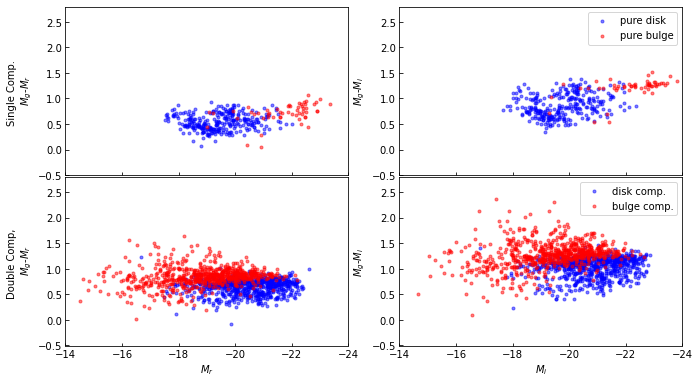

In [16]:
# _________________________________________________________
# _________________________________________________________
#-- Making a colour magnitude diagram --#
# _________________________________________________________

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows = 2, ncols = 2,sharex=True,figsize=(10,6))
fig.tight_layout(pad=3.6)
fig.subplots_adjust(hspace=0.01,wspace=0.18)
    
index = np.argwhere(xGASS_data['Model']==1)
ax1.scatter(xGASS_data['Mag_r'][index],xGASS_data['Mag_g'][index] - xGASS_data['Mag_r'][index],alpha=0.5,marker='.',color='b')
ax2.scatter(xGASS_data['Mag_i'][index],xGASS_data['Mag_g'][index] - xGASS_data['Mag_i'][index],alpha=0.5,marker='.',color='b',label='pure disk')
index = np.argwhere(xGASS_data['Model']==2)
ax1.scatter(xGASS_data['Mag_r'][index],xGASS_data['Mag_g'][index] - xGASS_data['Mag_r'][index],alpha=0.5,marker='.',color='r')
ax2.scatter(xGASS_data['Mag_i'][index],xGASS_data['Mag_g'][index] - xGASS_data['Mag_i'][index],alpha=0.5,marker='.',color='r',label='pure bulge')

ax2.legend()

index = np.argwhere(xGASS_data['Model']==0)
ax3.scatter(xGASS_data['MagD_r'][index],xGASS_data['MagD_g'][index] - xGASS_data['MagD_r'][index],alpha=0.5,marker='.',color='b')
ax4.scatter(xGASS_data['MagD_i'][index],xGASS_data['MagD_g'][index] - xGASS_data['MagD_i'][index],alpha=0.5,marker='.',color='b',label='disk comp.')
ax3.scatter(xGASS_data['MagB_r'][index],xGASS_data['MagB_g'][index] - xGASS_data['MagB_r'][index],alpha=0.5,marker='.',color='r')
ax4.scatter(xGASS_data['MagB_i'][index],xGASS_data['MagB_g'][index] - xGASS_data['MagB_i'][index],alpha=0.5,marker='.',color='r',label='bulge comp.')

ax4.legend()

ax1.set_ylabel('Single Comp. \n $M_{g}$-$M_{r}$')
ax2.set_ylabel('$M_{g}$-$M_{i}$')
ax3.set_ylabel('Double Comp, \n $M_{g}$-$M_{r}$')
ax4.set_ylabel('$M_{g}$-$M_{i}$')

ax3.set_xlabel('$M_{r}$')
ax4.set_xlabel('$M_{i}$')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xlim(-14,-24)
    ax.set_ylim(-0.5,2.8)
    ax.tick_params(axis='both',direction='in')

fig.savefig(path+'Figures/ColourMagDiagram.pdf')

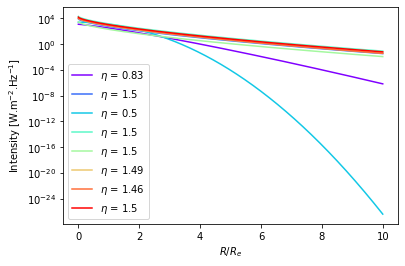

In [17]:
# _________________________________________________________
# _________________________________________________________
#-- Examples of sersic profiles to get started: --#
# _________________________________________________________

from   matplotlib.pyplot import cm

twoComp_galaxies = np.argwhere(xGASS_data['Model']==0)
c = cm.rainbow(np.linspace(0,1,len(twoComp_galaxies[::100])))
fig = plt.figure()
for j,i in enumerate(twoComp_galaxies[::100]):
    Re    = xGASS_data['reD_r_kpc'][i] #kpc
    n     = xGASS_data['nserD_r'][i]
    m     = xGASS_data['magD_r'][i] #apparent mag
    mzero = magzero['r'][i]

    ie = Ie(Re,n,m,mzero) #In units of Intensity I guess?
    R = Sersic_Profile(Re,ie,n)[0] #kpc
    y = Sersic_Profile(Re,ie,n)[1]

    plt.plot(R/Re,y,color=c[j],label=r'$\eta$ = '+str(round(n[0],2)))
    plt.yscale('log')
    plt.xlabel('$R/R_{e}$')
    plt.ylabel('Intensity [W.m$^{-2}$.Hz$^{-1}$]')
    plt.legend()
fig.savefig(path+'Figures/Example_xGASS_SersicProfiles.pdf')

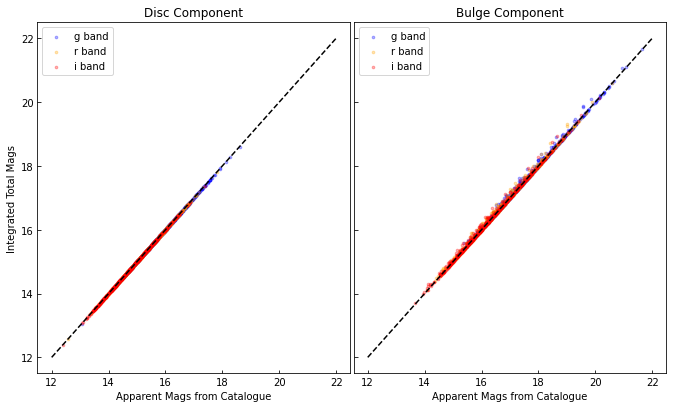

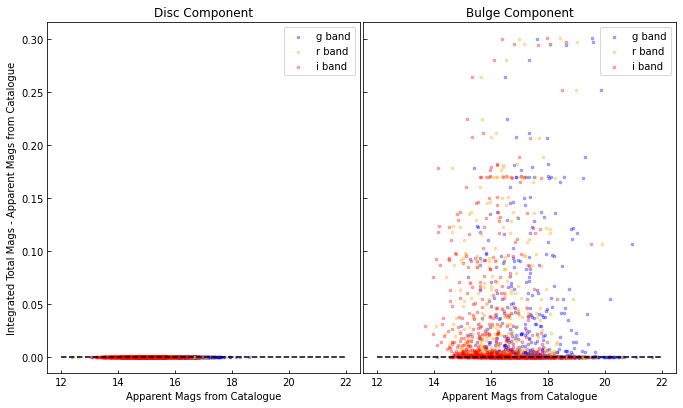

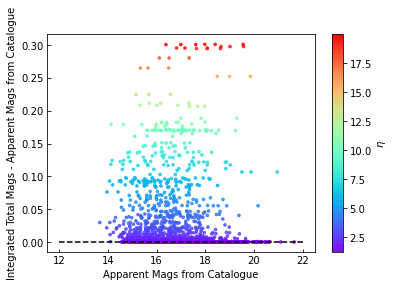

In [18]:
# _________________________________________________________
# _________________________________________________________
#--Plot Integral solution and catalogue solution one-to-one --#
# _________________________________________________________


fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,6),sharey=True,sharex=True)
fig.tight_layout(pad=3)
fig.subplots_adjust(wspace=0.01,hspace=0.01)

ax1.set_ylabel('Integrated Total Mags')

ax1.set_title('Disc Component')
ax2.set_title('Bulge Component')

for type in ['D','B']:
    if type == 'D':
        ax = ax1
    if type == 'B':
        ax = ax2
    for band in ['g','r','i']:
        if band == 'g':
            c = 'b'
        if band == 'r':
            c = 'orange'
        if band == 'i':
            c = 'r'
        ax.scatter(xGASS_data['mag'+type+'_'+band][twoComp_galaxies],TotalMag[type+band],color=c,alpha=0.3,s=7,label=band+' band')

for ax in [ax1,ax2]:
    ax.plot([12,22],[12,22],color='k',ls='--')
    ax.legend()
    ax.set_xlabel('Apparent Mags from Catalogue')
    ax.tick_params(axis='both',direction='in')

fig.savefig(path+'Figures/ComparingMagActual_vs_Int.pdf')

#--

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,6),sharey=True,sharex=True)
fig.tight_layout(pad=3)
fig.subplots_adjust(wspace=0.01,hspace=0.01)
for type in ['D','B']:
    if type == 'D':
        ax = ax1
    if type == 'B':
        ax = ax2
    for band in ['g','r','i']:
        if band == 'g':
            c = 'b'
        if band == 'r':
            c = 'orange'
        if band == 'i':
            c = 'r'
        ax.scatter(xGASS_data['mag'+type+'_'+band][twoComp_galaxies],TotalMag[type+band] - xGASS_data['mag'+type+'_'+band][twoComp_galaxies],
                    color=c,alpha=0.3,s=7,label=band+' band')

for ax in [ax1,ax2]:
    ax.plot([12,22],[0,0],color='k',ls='--')
    ax.legend()
    ax.set_xlabel('Apparent Mags from Catalogue')
    ax.tick_params(axis='both',direction='in')

ax1.set_ylabel('Integrated Total Mags - Apparent Mags from Catalogue')

ax1.set_title('Disc Component')
ax2.set_title('Bulge Component')

fig.savefig(path+'Figures/ComparingMagActual_Int_ratio.pdf')

#--

fig = plt.figure()
fig.tight_layout(pad=3)
fig.subplots_adjust(wspace=0.01,hspace=0.01)

cm = plt.cm.get_cmap('rainbow')

type = 'B'
for band in ['g','r','i']:
    sc = plt.scatter(xGASS_data['mag'+type+'_'+band][twoComp_galaxies],TotalMag[type+band] - xGASS_data['mag'+type+'_'+band][twoComp_galaxies],
                      cmap=cm,c=xGASS_data['nser'+type+'_'+band][twoComp_galaxies],alpha=0.8,s=7)

plt.colorbar(sc,label='$\eta$')

plt.plot([12,22],[0,0],color='k',ls='--')
plt.xlabel('Apparent Mags from Catalogue')
plt.tick_params(axis='both',direction='in')

plt.ylabel('Integrated Total Mags - Apparent Mags from Catalogue')

fig.savefig(path+'Figures/ComparingMagActual_Int_ratio_nColour200Re.pdf')


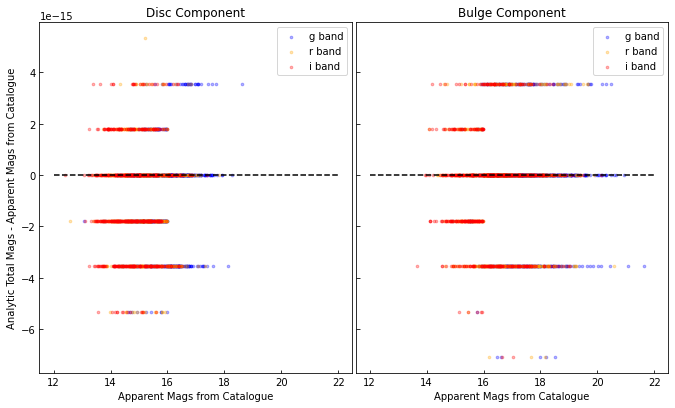

In [19]:
# _________________________________________________________
# _________________________________________________________
#-- Compare analytic solutions to actual solutions: --#
# _________________________________________________________


fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,6),sharey=True,sharex=True)
fig.tight_layout(pad=3)
fig.subplots_adjust(wspace=0.01,hspace=0.01)
for type in ['D','B']:
    if type == 'D':
        ax = ax1
    if type == 'B':
        ax = ax2
    for band in ['g','r','i']:
        if band == 'g':
            c = 'b'
        if band == 'r':
            c = 'orange'
        if band == 'i':
            c = 'r'
        ax.scatter(xGASS_data['mag'+type+'_'+band][twoComp_galaxies],tmAnalytic[type+band] - xGASS_data['mag'+type+'_'+band][twoComp_galaxies],
                    color=c,alpha=0.3,s=7,label=band+' band')


for ax in [ax1,ax2]:
    ax.plot([12,22],[0,0],color='k',ls='--')
    ax.legend()
    ax.set_xlabel('Apparent Mags from Catalogue')
    ax.tick_params(axis='both',direction='in')

ax1.set_ylabel('Analytic Total Mags - Apparent Mags from Catalogue')

ax1.set_title('Disc Component')
ax2.set_title('Bulge Component')

fig.savefig(path+'Figures/ComparingMagActual_Analytic_ratio.pdf')

